

# Mentor-Mentee Match, via Vectorization, PCA(Principal Component Analysis), Clustering, and Test Search for the Best Model

# This notebook is part#1, Vectorization, part#2 PCA, part#3 Clustering, and part#4 Test Search for the Best Model

# Goal: modeling the possibility in end-result match of 1 mentee to multiple mentor candidates, or 1 mentor to multiple mentee candidates, or multiple mentor and mentee candidates in the same clustering. By vectorization and PCA preparation, for clustering of mentor and mentee in the similarity group of same interests, by considering gender, time zone, interest of life, and tech stack. One similarity group in one clustering of mentor and mentee; then the client can manually choose within the same clustering for the final match, as the client mentioned currently they would still prefer human intelligence for the final match with various reasons. The benefit of this model is one mentor may have bandwidth to coach multiple mentees, and one mentee may have several optional mentors for match-maker's decision; delivered by reading the same clustering the options provided for the match-maker.



In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
#from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook as tqdm

In [ ]:
# mock-up dataset in csv file with 10 observations
# we could also take the excel file from client converted to csv for modeling experiments

raw_df  = pd.read_csv('Mentor_Mentee.csv')

# The dataset (could be an excel file from client) consists of personal info, tech stack(For mentee, it is the interest level to learn on scale of 1 to 10. For mentor, it is the proficiency level on scale of 1 to 10.) Bios, could be a check-box type survey or each person's own words; and list of different interests of life on scale of 1 to 10.

In [ ]:
raw_df.head()

,ID,First Name,Last Name,Gender,Time zone,Bios,Python,SQL,iOS,Android,CSS,HTML,JavaScript,Movies,TV,Religion,Music,Sports,Books,Video Games,Mentor,Mentee
0,1,John,Smith,M,mountain,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer,10,8,0,0,5,10,10,5,3,4,1,3,6,7,1,0
1,2,Jane,Doe,F,mountain,web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover,10,10,0,0,0,9,9,7,9,5,1,9,4,10,0,1
2,3,Mike,Masters,M,central,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,10,9,8,8,9,9,10,1,2,6,5,6,5,10,1,0
3,4,Tim,Andersen,M,eastern,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,5,5,0,0,10,10,10,5,2,7,8,2,6,6,1,0
4,5,Miles,Tam,M,pacific,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,0,0,0,0,10,10,10,6,6,6,4,3,6,3,0,1


# Start preparing vectorization

In [ ]:
df = raw_df.drop(['ID', 'First Name', 'Last Name',
                                        'Gender', 'Time zone'],axis=1)

In [ ]:
df.head()

,Bios,Python,SQL,iOS,Android,CSS,HTML,JavaScript,Movies,TV,Religion,Music,Sports,Books,Video Games,Mentor,Mentee
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer,10,8,0,0,5,10,10,5,3,4,1,3,6,7,1,0
1,web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover,10,10,0,0,0,9,9,7,9,5,1,9,4,10,0,1
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,10,9,8,8,9,9,10,1,2,6,5,6,5,10,1,0
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,5,5,0,0,10,10,10,5,2,7,8,2,6,6,1,0
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,0,0,0,0,10,10,10,6,6,6,4,3,6,3,0,1


In [ ]:
def string_convert(x):
    """
    First converts the lists in the DF into strings
    """
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x
    
# Looping through the columns and applying the function
for col in df.columns:
    df[col] = df[col].apply(string_convert)

In [ ]:
df

,Bios,Python,SQL,iOS,Android,CSS,HTML,JavaScript,Movies,TV,Religion,Music,Sports,Books,Video Games,Mentor,Mentee
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer,10,8,0,0,5,10,10,5,3,4,1,3,6,7,1,0
1,web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover,10,10,0,0,0,9,9,7,9,5,1,9,4,10,0,1
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,10,9,8,8,9,9,10,1,2,6,5,6,5,10,1,0
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,5,5,0,0,10,10,10,5,2,7,8,2,6,6,1,0
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,0,0,0,0,10,10,10,6,6,6,4,3,6,3,0,1
5,Pop culture junkie. TV buff. Reader. Friendly travel expert. Incurable twitteraholic. Social media ninja. Coffee enthusiast. Internet specialist,0,0,10,10,0,0,0,0,5,7,5,9,2,0,1,0
6,Typical thinker. Amateur explorer. Reader. Extreme student. TV fanatic. Social media ninja.,0,0,10,10,0,0,0,5,4,7,5,0,8,4,0,1
7,zombit marven. Travel geek. Professional social media buff. Avid pop culture lover.,7,7,0,0,10,10,10,9,8,8,2,0,0,5,0,1
8,lifelong introvert. General travel maven. Hipster-friendly web trailblazer. Writter. Alcohol fan. Student. Communicator. Coffee guru.,10,10,5,5,5,9,9,8,8,2,6,1,2,9,0,1
9,travel ninja. Amateur pop culture evangelist. Web fanatic. Freelance communicator. Zombie geek.,0,0,10,10,10,10,10,9,0,2,2,5,6,8,1,0


# Vectorization

In [ ]:
def vectorization(df, columns):
    """
    Using recursion, iterate through the df until all the categories have been vectorized
    """
    column_name = columns[0]
    
    # Checking if the column name has been removed already
    if column_name not in ['Bios', 'Movies','Religion', 'Music', 'Books', 'Sports']:
        return df
    
    if column_name in ['Religion']:
        df[column_name.lower()] = df[column_name].cat.codes
        
        df = df.drop(column_name, 1)
        
        return vectorization(df, df.columns)
    
    else:
        # Instantiating the Vectorizer
        vectorizer = CountVectorizer()
        
        # Fitting the vectorizer to the Bios
        x = vectorizer.fit_transform(df[column_name])

        # Creating a new DF that contains the vectorized words
        df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

        # Concating the words DF with the original DF
        new_df = pd.concat([df, df_wrds], axis=1)

        # Dropping the column because it is no longer needed in place of vectorization
        new_df = new_df.drop(column_name, axis=1)
        
        return vectorization(new_df, new_df.columns) 
        

In [ ]:
# Creating the vectorized DF
vect_df = vectorization(df, df.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Scaling the data

# It will assist our clustering algorithm’s performance, is scaling categories. This will potentially decrease the time it takes to fit and transform our clustering algorithm to the dataset.


In [ ]:
scaler = MinMaxScaler()
# vect_df  = pd.DataFrame(scaler.fit_transform(new_df), 
#                                columns=new_df.columns,
#                                index=new_df.index)


vect_df = pd.DataFrame(scaler.fit_transform(vect_df), index=vect_df.index, columns=vect_df.columns)

#pd.DataFrame(scaler.fit_transform(vect_df), index=vect_df.index, columns=vect_df.columns)

In [ ]:
# Creating a new DF that contains the vectorized words
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['Bios'])
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
df_wrds

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,alcohol,amateur,analyst,avid,bacon,buff,coffee,communicator,culture,down,enthusiast,entrepreneur,evangelist,expert,explorer,extreme,falls,fan,fanatic,food,freelance,friendly,gamer,geek,general,guru,hipster,humble,incurable,infuriatingly,internet,introvert,junkie,lifelong,lot,lover,marven,maven,media,music,nerd,ninja,organizer,pop,practitioner,professional,reader,scholar,social,specialist,student,thinker,trailblazer,travel,tv,twitter,twitteraholic,typical,web,writter,zombie,zombit
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0
7,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0
9,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [ ]:
# Concatenating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
new_df.drop('Bios', axis=1, inplace=True)

# Viewing the new DF
new_df

,Python,SQL,iOS,Android,CSS,HTML,JavaScript,Movies,TV,Religion,Music,Sports,Books,Video Games,Mentor,Mentee,alcohol,amateur,analyst,avid,bacon,buff,coffee,communicator,culture,down,enthusiast,entrepreneur,evangelist,expert,explorer,extreme,falls,fan,fanatic,food,freelance,friendly,gamer,geek,general,guru,hipster,humble,incurable,infuriatingly,internet,introvert,junkie,lifelong,lot,lover,marven,maven,media,music,nerd,ninja,organizer,pop,practitioner,professional,reader,scholar,social,specialist,student,thinker,trailblazer,travel,tv,twitter,twitteraholic,typical,web,writter,zombie,zombit
0,10,8,0,0,5,10,10,5,3,4,1,3,6,7,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1,10,10,0,0,0,9,9,7,9,5,1,9,4,10,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,10,9,8,8,9,9,10,1,2,6,5,6,5,10,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,5,5,0,0,10,10,10,5,2,7,8,2,6,6,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,10,10,10,6,6,6,4,3,6,3,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,10,10,0,0,0,0,5,7,5,9,2,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0
6,0,0,10,10,0,0,0,5,4,7,5,0,8,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0
7,7,7,0,0,10,10,10,9,8,8,2,0,0,5,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8,10,10,5,5,5,9,9,8,8,2,6,1,2,9,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0
9,0,0,10,10,10,10,10,9,0,2,2,5,6,8,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [ ]:
new_df.shape

(10, 78)

#Part#2, PCA(Principal Component Analysis)

#In order for us to reduce this large feature set, we implement PCA. This technique will reduce the dimensionality of our dataset but still retain much of the variability or valuable statistical information.

# The following plot will visually tell us the number of features account for the variance.

# X axis: # of Features accounting for % of the Variance
# Y axis: Percent of variance


[0.46490907 0.64503732 0.78693831 0.85267768 0.90996079 0.9570419
 0.97795939 0.99095967 1.         1.        ]


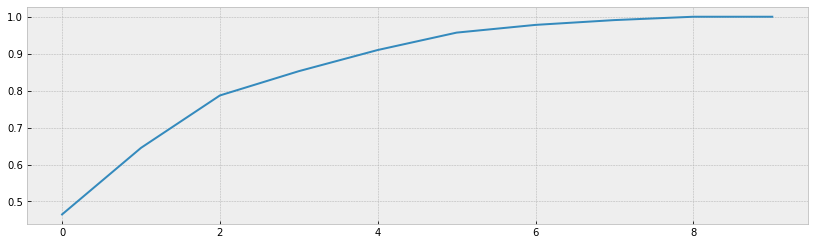

[0.46490907 0.64503732 0.78693831 0.85267768 0.90996079 0.9570419
 0.97795939 0.99095967 1.         1.        ]


In [ ]:
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
print(pca.explained_variance_ratio_.cumsum()) 
plt.plot(np.cumsum((pca.explained_variance_ratio_)))
plt.show()
print(np.cumsum((pca.explained_variance_ratio_)))



#After running our code, the number of features that account for 95% of the variance is 6. With that number in mind, we can apply it to our PCA function to reduce the number of Principal Components or Features in our last DF to 6 from 10.

#Finding the Right Number of Clusters

# Below, we will be running some code that will run our clustering algorithm with differing amounts of clusters.

In [ ]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 9, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# The DF for evaluation
eval_df = df_pca

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    clust = AgglomerativeClustering(n_clusters=i, linkage='complete')
    
    clust.fit(eval_df)
    
    cluster_assignments = clust.labels_
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(eval_df, cluster_assignments))
    
    s_scores.append(silhouette_score(eval_df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(eval_df, cluster_assignments))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/7 [00:00<?, ?it/s]

#Part #3, Clustering

#Find the optimum number of clusters

# The optimum number of clusters will be determined based on specific evaluation metrics which will quantify the performance of the clustering algorithms. Since there is no definite set number of clusters to create, we will be using a couple of different evaluation metrics to determine the optimum number of clusters. These metrics are the Silhouette Coefficient and the Davies-Bouldin Score.
# These metrics each have their own advantages and disadvantages. The choice to use either one is purely subjective and another metric can be chosen as well.

In [ ]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

# In the following, higher score meant higher relevancy.


The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
2       5.281653

Min Value:
Cluster #    Cluster Score
7       3.877209


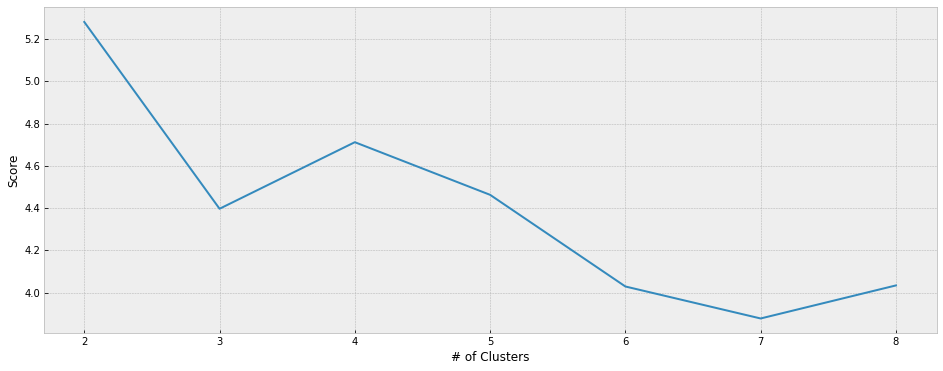


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
2       0.303195

Min Value:
Cluster #    Cluster Score
8       0.065398


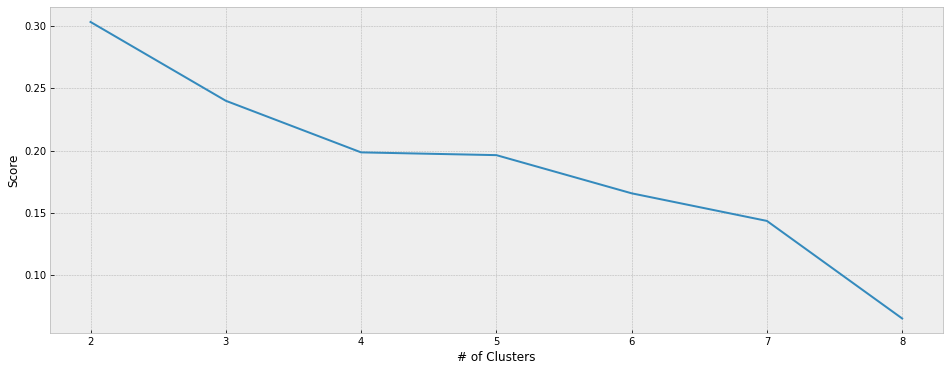


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
2        1.12763

Min Value:
Cluster #    Cluster Score
8       0.439425


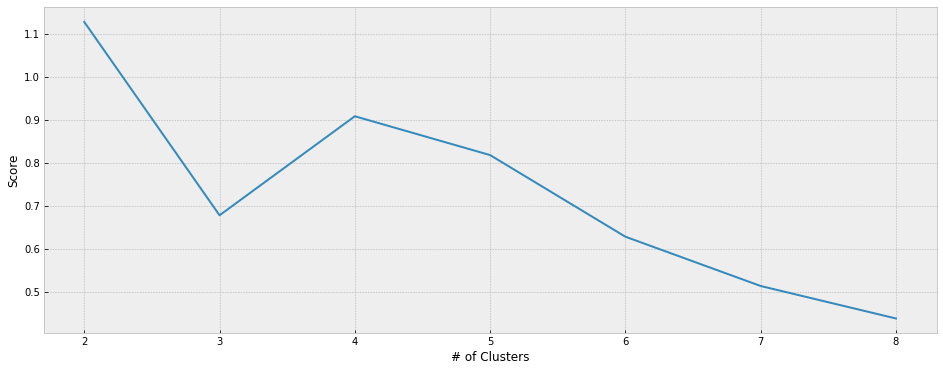

In [ ]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

#Running the Final Clustering Algorithm

#With everything ready, we can finally discover the clustering assignments for each mentor and mentee candidate.

In [ ]:
# Instantiating HAC based on the optimum number of clusters found
hac = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

#With the mock dataset,
#Cluster#0, shown 3 mentors and 4 mentees in one clustering for the match-maker.
#Cluster#1, shown 1 mentor and 1 mentee in one clustering
# Cluster#2, shown 1 mentor and 0 mentee in one clustering

In [ ]:
df.head(10)

,Bios,Python,SQL,iOS,Android,CSS,HTML,JavaScript,Movies,TV,Religion,Music,Sports,Books,Video Games,Mentor,Mentee,Cluster #
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer,10,8,0,0,5,10,10,5,3,4,1,3,6,7,1,0,0
1,web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover,10,10,0,0,0,9,9,7,9,5,1,9,4,10,0,1,0
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,10,9,8,8,9,9,10,1,2,6,5,6,5,10,1,0,0
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,5,5,0,0,10,10,10,5,2,7,8,2,6,6,1,0,0
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,0,0,0,0,10,10,10,6,6,6,4,3,6,3,0,1,0
5,Pop culture junkie. TV buff. Reader. Friendly travel expert. Incurable twitteraholic. Social media ninja. Coffee enthusiast. Internet specialist,0,0,10,10,0,0,0,0,5,7,5,9,2,0,1,0,1
6,Typical thinker. Amateur explorer. Reader. Extreme student. TV fanatic. Social media ninja.,0,0,10,10,0,0,0,5,4,7,5,0,8,4,0,1,1
7,zombit marven. Travel geek. Professional social media buff. Avid pop culture lover.,7,7,0,0,10,10,10,9,8,8,2,0,0,5,0,1,0
8,lifelong introvert. General travel maven. Hipster-friendly web trailblazer. Writter. Alcohol fan. Student. Communicator. Coffee guru.,10,10,5,5,5,9,9,8,8,2,6,1,2,9,0,1,0
9,travel ninja. Amateur pop culture evangelist. Web fanatic. Freelance communicator. Zombie geek.,0,0,10,10,10,10,10,9,0,2,2,5,6,8,1,0,2


#Part#4, search for best model

#Prepare to find out the best model 

In [ ]:
# Importing 3 models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Assigning the split variables
X = vect_df.drop(["Cluster #"], 1)
y = vect_df['Cluster #']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


#Different model tests to find out best model

In [ ]:
# Dummy
dummy = DummyClassifier(strategy='stratified')

# KNN
knn = KNeighborsClassifier()

# SVM
svm = SVC(gamma='scale')

# NaiveBayes
nb = ComplementNB()

# Logistic Regression
lr = LogisticRegression()

# Adaboost
adab = AdaBoostClassifier()

# List of models
models = [dummy, knn, svm, nb, lr, adab]

# List of model names
names = ['Dummy', 'KNN', 'SVM', 'NaiveBayes', 'Logistic Regression', 'Adaboost']

# Zipping the lists
classifiers = dict(zip(names, models))

#The following result shown, the KNN is the best model
#KNN Score: 1.0; most likely the mock data is only 10 observations that caused overfitting

In [ ]:
# Dictionary containing the model names and their scores
models_f1 = {}

# Looping through each model's predictions and getting their classification reports
for name, model in tqdm(classifiers.items()):
    # Fitting the model
    model.fit(X_train, y_train)
    
    print('\n'+ name + ' (Macro Avg - F1 Score):')
    
    # Classification Report
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    f1 = report['macro avg']['f1-score']
    
    # Assigning to the Dictionary
    models_f1[name] = f1
    
    print(f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe


Dummy (Macro Avg - F1 Score):
0.16666666666666666

KNN (Macro Avg - F1 Score):
1.0

SVM (Macro Avg - F1 Score):
1.0

NaiveBayes (Macro Avg - F1 Score):
0.4

Logistic Regression (Macro Avg - F1 Score):
1.0

Adaboost (Macro Avg - F1 Score):
1.0


In [ ]:
print(max(models_f1, key=models_f1.get), 'Score:', max(models_f1.values()))

KNN Score: 1.0



# Then, work with web team on app file

# It will be very interesting to use the client's existing excel file dataset to run experiments on all-the-above and refine to final codes to use. 

#END of best model search